In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import sys
print(sys.executable)

/Users/adminpc-macmini/Documents/Code/Libaries/python_jupyter_venv/bin/python


In [4]:
!jupyter kernelspec list

Available kernels:
  python3    /Users/adminpc-macmini/Documents/Code/Libaries/python_jupyter_venv/share/jupyter/kernels/python3


In [5]:
import glob
import random
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from skimage import color
from skimage import io
from skimage.transform import resize

2023-12-06 19:42:44.308841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        print('enable gpu')
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [7]:
ROOT_FILE_PATH = "/Volumes/ESD-USB/files/2023-Machine-Learning-Dataset"
AREAS = ["prf-visualrois", "floc-bodies", "floc-faces", "floc-places", "floc-words", "streams", "all-vertices"]
MASK_KEYS = ["lh.fsaverage_space", "rh.fsaverage_space", "lh.space", "rh.space", "mapping"]

In [8]:
def ReadNpyFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename] = np.load(path, allow_pickle = True)
  return return_dic

def ReadFmriFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename[0]] = np.load(path, allow_pickle = True)
  return return_dic

def ReadMaskFile(dir_path):
  return_dic = {area: {} for area in AREAS}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    for area in AREAS:
      if area in filename:
        filename = "".join(i.strip("_") for i in filename.split(area))
        return_dic[area][filename] = np.load(path, allow_pickle = True) if filename[0] != "m" else np.load(path, allow_pickle = True).item()
        break
  return return_dic

def FetchPngFile(dir_path, index, mode = "rgb"):
  # img = iio.v3.imread()
  img = io.imread(os.path.join(dir_path, f'{index}.png'))
  if mode == "rgb":
    return img
  if mode == "hsv":
    return color.rgb2hsv(img)
    # return matplotlib.colors.rgb_to_hsv(img)
  if mode == "gray":
    return color.rgb2gray(img)
    # return np.dot(img, [0.299, 0.587, 0.114])

In [9]:
def train_val_split(x, y, ratio, random_state=42):
  
  r = np.random.RandomState(random_state)
  
  idx = r.permutation(x.index)
  x_per = x.reindex(idx)
  y_per = y.reindex(idx)

  train_size = int(x.shape[0] * ratio)
  
  x_train = x_per[0:train_size]
  y_train = y_per[0:train_size]
  
  x_val = x_per[train_size:]
  y_val = y_per[train_size:]
  
  print('Training_dimension: ' + str(x_train.shape) + ' | ' + str(y_train.shape))
  print('Validation_dimension: ' + str(x_val.shape) + ' | ' + str(y_val.shape))

  return x_train, x_val, y_train, y_val

In [15]:
class ReadObject:
  
  #fmri = None           # dict(string -> ndarray, float32)
  #masks = None          # dict(string "AREA" -> (dict(int -> string), string "HEMISPHERE, " -> ndarray))
  
  #image_labels = None   # dataframe
  #label_names = None    # list

  subject = None        # string
  
  def __init__(self, subject):
    self.subject = subject

  # Mode = "train" | "test"
  def load(self, mode = "train"):
    
    image_labels = pd.read_csv(os.path.join(ROOT_FILE_PATH, "image_infos", f"{self.subject}_infos_train.csv"))
    image_labels = image_labels.drop(image_labels.columns[[0, 1]], axis=1)
    
    label_names = image_labels.columns
    
    image_labels = image_labels.to_numpy(dtype=int)
    
    masks = ReadMaskFile(os.path.join(ROOT_FILE_PATH, self.subject , "roi_masks"))
    
    print(f'Images: {image_labels.shape[0]} | Labels: {image_labels.shape[1]} | Masks: {len(masks.keys())}')
        
    if mode == "train":
      fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_fmri"))
    elif mode == "test":
      fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "test_split", "test_fmri"))
          
    return label_names, image_labels, masks, fmri

  def split_data(self, image_labels, fmri, count=None, ratio=None, permutate=True, loadImages=False, image_mode = "gray", random_state=42):
    
    images_train = None
    images_val = None
    
    if ratio is None:
      ratio = 1
    
    random_state = np.random.RandomState(random_state)
    
    if count is not None and count > 0:
      fmri_l_copy = fmri['l'][:count]
      fmri_r_copy = fmri['r'][:count]
      labels_copy = image_labels[:count]
    else:
      fmri_l_copy = fmri['l']
      fmri_r_copy = fmri['r']
      labels_copy = image_labels
        
    if loadImages:
      loaded_images = np.stack([
        FetchPngFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_images"), i, mode = image_mode) for i in range(labels_copy.shape[0])
      ])
    
    if permutate:
      
        idx = random_state.permutation(labels_copy.shape[0])
        
        fmri_l_copy = fmri_l_copy[idx]
        fmri_r_copy = fmri_r_copy[idx]
        labels_copy = labels_copy[idx]
        
        if loadImages:
          loaded_images = loaded_images[idx]
        
    train_size = int(labels_copy.shape[0] * ratio)
  
    fmri_l_train = fmri_l_copy[0:train_size]
    fmri_r_train = fmri_r_copy[0:train_size]
    labels_train = labels_copy[0:train_size]
    
    if loadImages:
      images_train = loaded_images[0:train_size]
    
    fmri_l_val = fmri_l_copy[train_size:]
    fmri_r_val = fmri_r_copy[train_size:]
    labels_val = labels_copy[train_size:]
    
    if loadImages:
      images_val = loaded_images[train_size:]
    
    return (labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val)

In [16]:
%matplotlib inline
def test_data(label_names, labels_list, image, fmri_l, fmri_r):
  labels = np.array(label_names)[np.where(labels_list != 0)] 
  print(labels)
  plt.imshow(image, cmap='gray')
  plt.show()

In [17]:
SUBJ_LIST = ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08"]

In [18]:
def min_max_normalize(X, min=0, max=1):
  
  # Define the original range
  old_min = np.min(X)
  old_max = np.max(X)
  
  # Map the values from the original range to the new range
  X = (np.array(X, dtype='float32') - old_min) * (max - min) / (old_max - old_min) + min
  
  return X

In [29]:
global_labels_name = None
global_labels_train = None
global_labels_val = None
global_fmri_l_train = None
global_fmri_l_val = None
global_fmri_r_train = None
global_fmri_r_val = None
global_images_train = None
global_images_val = None

subject_count = 5
image_mode = "gray"
load_images = False

for sub in SUBJ_LIST[:subject_count]:
  
  print(sub)
  
  sub_obj = ReadObject(sub)
  label_names, image_labels, masks, fmri = sub_obj.load()
  
  global_labels_name = label_names if global_labels_name is None else global_labels_name
  
  ((labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val)) = (
    sub_obj.split_data(image_labels, fmri, count=5000, ratio=0.995, image_mode=image_mode, loadImages=load_images))
  
  print(f"labels_train  shape: {labels_train.shape}")
  global_labels_train = labels_train if global_labels_train is None else np.vstack((global_labels_train, labels_train))
  
  print(f"labels_val  shape: {labels_val.shape}")
  global_labels_val = labels_val if global_labels_val is None else np.vstack((global_labels_val, labels_val))
  
  fmri_l_train = min_max_normalize(fmri_l_train) # fmri_l_train / np.max(fmri_l_train)
  print(f"fmri_l_train  shape: {fmri_l_train.shape} | min: {np.min(fmri_l_train)} max: {np.max(fmri_l_train)}")
  global_fmri_l_train = fmri_l_train if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_train))
  
  fmri_l_val = min_max_normalize(fmri_l_val) # fmri_l_val / np.max(fmri_l_val)
  print(f"fmri_l_val  shape: {fmri_l_val.shape} | min: {np.min(fmri_l_val)} max: {np.max(fmri_l_val)}")
  global_fmri_l_val = fmri_l_val if global_fmri_l_val is None else np.vstack((global_fmri_l_val, fmri_l_val))
  
  fmri_r_train = min_max_normalize(fmri_r_train) # fmri_r_train / np.max(fmri_r_train)
  print(f"fmri_r_train  shape: {fmri_r_train.shape} | min: {np.min(fmri_r_train)} max: {np.max(fmri_r_train)}")
  global_fmri_r_train = fmri_r_train if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_train))
  
  fmri_r_val = min_max_normalize(fmri_r_val) # fmri_r_val / np.max(fmri_r_val)
  print(f"fmri_r_val  shape: {fmri_r_val.shape} | min: {np.min(fmri_r_val)} max: {np.max(fmri_r_val)}")
  global_fmri_r_val = fmri_r_val if global_fmri_r_val is None else np.vstack((global_fmri_r_val, fmri_r_val))
  
  if load_images:
  
    if image_mode == 'rgb':
      images_train = images_train / 255. 
    elif image_mode == 'gray':
      images_train = images_train.reshape((-1, images_train.shape[1], images_train.shape[2], 1))
    print(f"images_train  shape: {images_train.shape} | min: {np.min(images_train)} max: {np.max(images_train)}")
    global_images_train = images_train if global_images_train is None else np.vstack((global_images_train, images_train))
    
    if image_mode == 'rgb':
      images_val = images_val / 255. 
    elif image_mode == 'gray':
      images_val = images_val.reshape((-1, images_val.shape[1], images_val.shape[2], 1))
    print(f"images_val  shape: {images_val.shape} | min: {np.min(images_val)} max: {np.max(images_val)}")
    global_images_val = images_val if global_images_val is None else np.vstack((global_images_val, images_val))
  
  # Free memory
  labels_train, labels_val, fmri_l_train, fmri_l_val, fmri_r_train, fmri_r_val, images_train, images_val = None, None, None, None, None, None, None, None
  label_names, image_labels, masks, fmri = None, None, None, None
  
  print('')

subj01
Images: 5000 | Labels: 133 | Masks: 7
labels_train  shape: (4975, 133)
labels_val  shape: (25, 133)
fmri_l_train  shape: (4975, 19004) | min: 0.0 max: 1.0
fmri_l_val  shape: (25, 19004) | min: 0.0 max: 1.0
fmri_r_train  shape: (4975, 20544) | min: 0.0 max: 1.0
fmri_r_val  shape: (25, 20544) | min: 0.0 max: 1.0

subj02
Images: 5000 | Labels: 133 | Masks: 7
labels_train  shape: (4975, 133)
labels_val  shape: (25, 133)
fmri_l_train  shape: (4975, 19004) | min: 0.0 max: 1.0
fmri_l_val  shape: (25, 19004) | min: 0.0 max: 1.0
fmri_r_train  shape: (4975, 20544) | min: 0.0 max: 1.0
fmri_r_val  shape: (25, 20544) | min: 0.0 max: 1.0

subj03
Images: 5000 | Labels: 133 | Masks: 7
labels_train  shape: (4975, 133)
labels_val  shape: (25, 133)
fmri_l_train  shape: (4975, 19004) | min: 0.0 max: 1.0
fmri_l_val  shape: (25, 19004) | min: 0.0 max: 1.0
fmri_r_train  shape: (4975, 20544) | min: 0.0 max: 1.0
fmri_r_val  shape: (25, 20544) | min: 0.0 max: 1.0

subj04
Images: 5000 | Labels: 133 | Mask

In [30]:
print('Global shapes:')
print(global_labels_train.shape)
print(global_labels_val.shape)
print(global_fmri_l_train.shape)
print(global_fmri_l_val.shape)
print(global_fmri_r_train.shape)
print(global_fmri_r_val.shape)

if load_images:
  print(global_images_train.shape)
  print(global_images_val.shape)

Global shapes:
(24875, 133)
(125, 133)
(24875, 19004)
(125, 19004)
(24875, 20544)
(125, 20544)


In [31]:
if load_images:
  label_test_training_index = random.randint(0, global_labels_train.shape[0] - 1)
  print(f'Label test of training data {label_test_training_index}:')
  test_data(global_labels_name, global_labels_train[label_test_training_index], global_images_train[label_test_training_index], None, None)

In [32]:
print(f'Global labels:')
global_Y_train_classification = global_labels_train
print(global_Y_train_classification.shape)

Global labels:
(24875, 133)


In [33]:
from tensorflow import keras

# Preprocess fmri to 2D

In [34]:
print(f'Expand and combine fmri data train:')

target_size = 21025

print(global_fmri_l_train.shape)
additional_rows = np.zeros(shape=(global_fmri_l_train.shape[0], target_size - global_fmri_l_train.shape[1]))
global_fmri_l_train_expended = np.concatenate((global_fmri_l_train, additional_rows), axis=1)
#print(global_fmri_l_train_expended.shape)

##

print(global_fmri_r_train.shape)
additional_rows = np.zeros(shape=(global_fmri_r_train.shape[0], target_size - global_fmri_r_train.shape[1]))
global_fmri_r_train_expended = np.concatenate((global_fmri_r_train, additional_rows), axis=1)
#print(global_fmri_r_train_expended.shape)

global_X_train_2D = np.stack([global_fmri_l_train_expended, global_fmri_r_train_expended], axis=-1)
global_X_train_2D = global_X_train_2D.reshape(-1, 145, 145, 2)
print(global_X_train_2D.shape)

global_fmri_l_train_expended = None
global_fmri_r_train_expended = None

print(f'\nExpand and combine fmri data val:')

print(global_fmri_l_val.shape)
additional_rows = np.zeros(shape=(global_fmri_l_val.shape[0], target_size - global_fmri_l_val.shape[1]))
global_fmri_l_val_expended = np.concatenate((global_fmri_l_val, additional_rows), axis=1)
#print(global_fmri_l_val_expended.shape)

##

print(global_fmri_r_val.shape)
additional_rows = np.zeros(shape=(global_fmri_r_val.shape[0], target_size - global_fmri_r_val.shape[1]))
global_fmri_r_val_expended = np.concatenate((global_fmri_r_val, additional_rows), axis=1)
#print(global_fmri_r_val_expended.shape)

global_X_val_2D = np.stack([global_fmri_l_val_expended, global_fmri_r_val_expended], axis=-1)
global_X_val_2D = global_X_val_2D.reshape(-1, 145, 145, 2)
print(global_X_val_2D.shape)

global_fmri_l_val_expended = None
global_fmri_r_val_expended = None
additional_rows = None

Expand and combine fmri data train:
(24875, 19004)
(24875, 20544)
(24875, 145, 145, 2)

Expand and combine fmri data val:
(125, 19004)
(125, 20544)
(125, 145, 145, 2)


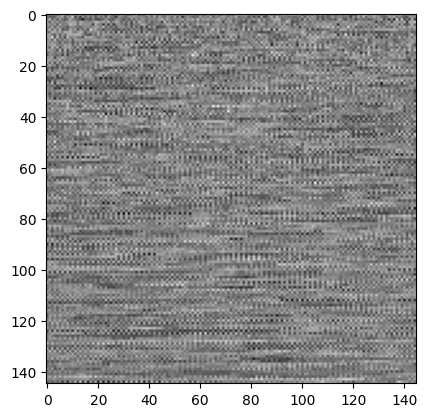

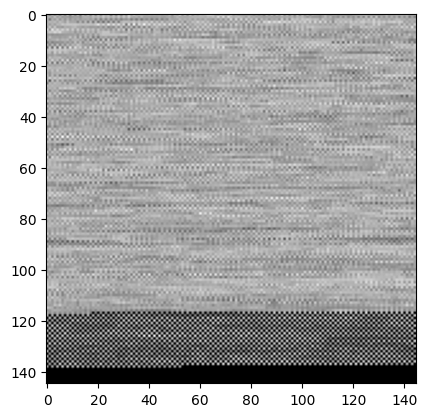

In [35]:
fmri_test_training_index = random.randint(0, global_X_train_2D.shape[0] - 1)
plt.imshow(global_X_train_2D[fmri_test_training_index].reshape(2, 145, 145)[0], cmap='gray')
plt.show()
plt.imshow(global_X_train_2D[fmri_test_training_index].reshape(2, 145, 145)[1], cmap='gray')
plt.show()

# Image classification

In [36]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=2, input_shape=(145, 145, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
#model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
#model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
#model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(133, activation="softmax"))

model.compile(
  optimizer= keras.optimizers.SGD(learning_rate=0.000001), loss= keras.losses.CategoricalCrossentropy(), metrics= [keras.metrics.CategoricalAccuracy()]
) 

model.summary()

2023-12-06 19:51:11.683459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        608       
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 73, 73, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 37, 37, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 37, 37, 32)        0

In [37]:
history = None
history = model.fit(global_X_train_2D, global_labels_train, validation_data=(global_X_val_2D, global_labels_val), batch_size=64, epochs=50)

Epoch 1/50
389/389 [==============================] - 435s 1s/step - loss: 32.4528 - categorical_accuracy: 0.1300 - val_loss: 32.7279 - val_categorical_accuracy: 0.1360
Epoch 2/50
389/389 [==============================] - 376s 967ms/step - loss: 36.2349 - categorical_accuracy: 0.3050 - val_loss: 40.8592 - val_categorical_accuracy: 0.2240
Epoch 3/50
389/389 [==============================] - 373s 960ms/step - loss: 43.5006 - categorical_accuracy: 0.2866 - val_loss: 49.9798 - val_categorical_accuracy: 0.2320
Epoch 4/50
389/389 [==============================] - 373s 960ms/step - loss: 51.2645 - categorical_accuracy: 0.3199 - val_loss: 58.4491 - val_categorical_accuracy: 0.2800
Epoch 5/50
389/389 [==============================] - 370s 952ms/step - loss: 59.9445 - categorical_accuracy: 0.3704 - val_loss: 67.9020 - val_categorical_accuracy: 0.3120
Epoch 6/50
389/389 [==============================] - 370s 952ms/step - loss: 69.8432 - categorical_accuracy: 0.3862 - val_loss: 79.0308 - val_

KeyboardInterrupt: 

In [ ]:
if history:
  
  # Accessing training history
  training_loss = history.history['loss']
  training_accuracy = history.history['accuracy']
  validation_loss = history.history['val_loss']
  validation_accuracy = history.history['val_accuracy']
  
  # Printing training and validation loss and accuracy
  for i in range(len(training_loss)):
      print(f"Epoch {i+1}: "
            f"Training Loss: {training_loss[i]}, "
            f"Training Accuracy: {training_accuracy[i]}, "
            f"Validation Loss: {validation_loss[i]}, "
            f"Validation Accuracy: {validation_accuracy[i]}"
            )

In [ ]:
keras.models.save_model(model, 'classification_model.h5')

In [ ]:
loaded_classification_model = keras.models.load_model('classification_model.h5')

In [38]:
prediction_model = model.predict(global_X_val_2D)
print(prediction_model.shape)

4/4 [==============================] - 1s 132ms/step
(125, 133)


In [39]:
prediction_model_index = random.randint(0, prediction_model.shape[0] - 1)
test_data(global_labels_name, global_labels_val[prediction_model_index], global_images_val[prediction_model_index], None, None)

TypeError: 'NoneType' object is not subscriptable

In [41]:
label_count = 3
print(prediction_model[prediction_model_index])
top_3_indices = np.argsort(prediction_model[prediction_model_index])[-label_count:][::-1]
top_3_values = prediction_model[prediction_model_index][top_3_indices]
print(f"Top 3 indices: {top_3_indices} | Top 3 values: {top_3_values}")
print("Top 3 labels:", global_labels_name[top_3_indices])

[5.02589881e-01 4.39233198e-11 2.75697493e-10 2.23172009e-07
 1.50638385e-07 8.71823835e-10 1.20437627e-09 9.65301410e-07
 1.06012196e-11 7.89317292e-11 5.65558844e-09 7.18837123e-09
 3.49401129e-12 8.13553502e-10 6.11257533e-08 3.89897593e-11
 3.52031452e-06 1.66504961e-08 8.43894554e-09 5.39491793e-07
 3.50950060e-08 6.42428404e-08 7.09152181e-12 1.05718962e-08
 4.34895719e-06 1.38118494e-09 1.98790076e-04 2.37971887e-13
 1.59999288e-11 3.00392903e-13 1.44721546e-09 1.62381308e-08
 1.06157430e-08 1.15525665e-07 3.55215787e-11 2.83340240e-09
 1.52807242e-08 2.46242143e-05 1.84235460e-10 9.55030337e-05
 6.49091580e-14 2.75537059e-05 1.53825486e-08 1.69680519e-08
 1.90522476e-11 5.04316033e-10 1.43693876e-10 4.22529503e-12
 2.85563538e-13 3.23842619e-10 6.34788541e-11 1.62179908e-14
 1.11556005e-06 1.77917698e-11 1.62096214e-09 8.26889107e-07
 1.81501255e-05 4.26980090e-10 7.32223310e-11 9.33823713e-11
 1.68310544e-05 2.72587188e-15 7.34564276e-09 5.03463804e-09
 6.46761182e-13 4.301055

# Image reconstruction 1

In [ ]:
## Resize images
size = 288
count = 100
resized_288_Y_train_images = np.zeros((count, size, size, global_images_train.shape[3]))
for index in range(count):
  if index % 50 == 0:
    print(index)
  resized_288_Y_train_images[index] = resize(global_images_train[index], (size, size, global_images_train.shape[3]), anti_aliasing=True)
print(resized_288_Y_train_images.shape)

In [ ]:
encoder1 = keras.models.Sequential()

encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(145, 145, 2)))
encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder1.summary()

decoder1 = keras.models.Sequential()

decoder1.add(keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(18, 18, 128)))
decoder1.add(keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(4, 4)))

decoder1.add(keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2DTranspose(resized_288_Y_train_images.shape[3], kernel_size=(3, 3), padding="same", activation='sigmoid'))
decoder1.summary()

model1 = keras.models.Sequential()
model1.add(encoder1)
model1.add(decoder1)

In [ ]:
model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy())
#model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.MSE())
#model1.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

In [ ]:
model1.fit(global_X_train_2D[:count], resized_288_Y_train_images, batch_size=32, epochs=10)

In [ ]:
keras.models.save_model(model1, 'reconstruction_model1.h5')

In [ ]:
loaded_reconstruction_model1 = keras.models.load_model('reconstruction_model1.h5')

In [ ]:
prediction_model1 = model1.predict(global_X_val_2D)
print(prediction_model1.shape)

In [ ]:
prediction_model1_index = random.randint(0, prediction_model1.shape[0] - 1)
test_data(global_labels_name, global_labels_val[prediction_model1_index], global_images_val[prediction_model1_index], None, None)
test_data(global_labels_name, global_labels_val[prediction_model1_index], prediction_model1[prediction_model1_index], None, None)

# Image reconstruction 2

In [ ]:
## Resize images
size = 230
count = 100
resized_230_Y_train_images = np.zeros((count, size, size, global_images_train.shape[3]))
for index in range(count):
  if index % 50 == 0:
    print(index)
  resized_230_Y_train_images[index] = resize(global_images_train[index], (size, size, global_images_train.shape[3]), anti_aliasing=True)
print(resized_230_Y_train_images.shape)

In [ ]:
encoder2 = keras.models.Sequential()

encoder2.add(keras.layers.Conv2D(32, kernel_size=4, strides=2, input_shape=(145, 145, 2)))
encoder2.add(keras.layers.Conv2D(32, kernel_size=4, strides=2))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))

encoder2.add(keras.layers.Conv2D(64, kernel_size=3, strides=2))
encoder2.add(keras.layers.Conv2D(64, kernel_size=3, strides=2))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))
encoder2.summary()

bridge2 = keras.models.Sequential()

bridge2.add(keras.layers.Conv2D(128, kernel_size=2, strides=2, input_shape=(7, 7, 64)))
bridge2.add(keras.layers.Conv2DTranspose(128, kernel_size=2, strides=2))
bridge2.summary()

decoder2 = keras.models.Sequential()

decoder2.add(keras.layers.BatchNormalization(input_shape=(6, 6, 128)))
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2))
decoder2.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(32, kernel_size=4, strides=2))
decoder2.add(keras.layers.Conv2DTranspose(32, kernel_size=4, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(resized_230_Y_train_images.shape[3], kernel_size=4, strides=2))

decoder2.summary()

model2 = keras.models.Sequential()

model2.add(encoder2)
model2.add(bridge2)
model2.add(decoder2)

model2.summary()

In [ ]:
#model2.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy())
model2.compile(optimizer= keras.optimizers.SGD(learning_rate=0.0001), loss='mse')
#model2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

In [ ]:
model2.fit(global_X_train_2D[:count], resized_230_Y_train_images, batch_size=64, epochs=60)

In [ ]:
keras.models.save_model(model2, 'reconstruction_model2.h5')

In [ ]:
loaded_reconstruction_model2 = keras.models.load_model('reconstruction_model2.h5')

In [ ]:
prediction_model2 = model2.predict(global_X_val_2D)
print(prediction_model2.shape)

In [ ]:
prediction_model2_index = random.randint(0, prediction_model2.shape[0] - 1)
test_data(global_labels_name, global_labels_val[prediction_model2_index], global_images_val[prediction_model2_index], None, None)
test_data(global_labels_name, global_labels_val[prediction_model2_index], prediction_model2[prediction_model2_index], None, None)